In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import scipy
import astropy

## Load data

In [3]:
def data_scope(arr, t_arr, t_start, t_stop):
    idxs = np.where((t_arr >= t_start) & (t_arr <= t_stop))[0]
    return arr[idxs]

def spike_scope(spikes, t_arr):
    hists = []
    for spike_train in spikes.item().values():
        hist, _ = np.histogram(spike_train, bins=np.append(t_arr, t_arr[-1] + t_arr[1] - t_arr[0]))
        hists.append(hist)
    hists = np.array(hists)
    return hists

In [4]:
data_path = '/Users/vemundss/Desktop/Toroidal_topology_grid_cell_data/'

In [5]:
with open(data_path + 'rat_q_sessions.txt') as file:
#with open(data_path + 'rat_r_day1_sessions.txt') as file:
#with open(data_path + 'rat_r_day2_sessions.txt') as file:
#with open(data_path + 'rat_s_sessions.txt') as file:
    sessions = file.readlines()
sessions

['#1,  sleep_box_1,        start=9576, end=18812   \n',
 '#2,  wagon_wheel_1,      start=18977, end=25355   \n',
 '#3,  sleep_box_2,        start=25403, end=27007   \n',
 '#4,  open_field_1,       start=27826, end=31223   \n']

In [6]:
data = {}

In [7]:
f = np.load(data_path + 'rat_q_grid_modules_1_2.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']

t_start, t_stop = 27826, 31223
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)

data['rat_q'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2}}

In [8]:
f = np.load(data_path + 'rat_r_day1_grid_modules_1_2_3.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']
spikes3 = f['spikes_mod3']

t_start, t_stop = 7457, 14778
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)
spikes3 = spike_scope(f['spikes_mod3'], t)

data['rat_r_day1'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2, 3: spikes3}}

# can add second slice (valid times) 14890, 16045 here

In [9]:
f = np.load(data_path + 'rat_r_day2_grid_modules_1_2_3.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']
spikes3 = f['spikes_mod3']

t_start, t_stop = 10617, 13004
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)
spikes3 = spike_scope(f['spikes_mod3'], t)

data['rat_r_day2'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2, 3: spikes3}}

In [10]:
f = np.load(data_path + 'rat_s_grid_modules_1.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']

t_start, t_stop = 9939, 12363
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)

data['rat_s'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1}}

## Create ratemaps

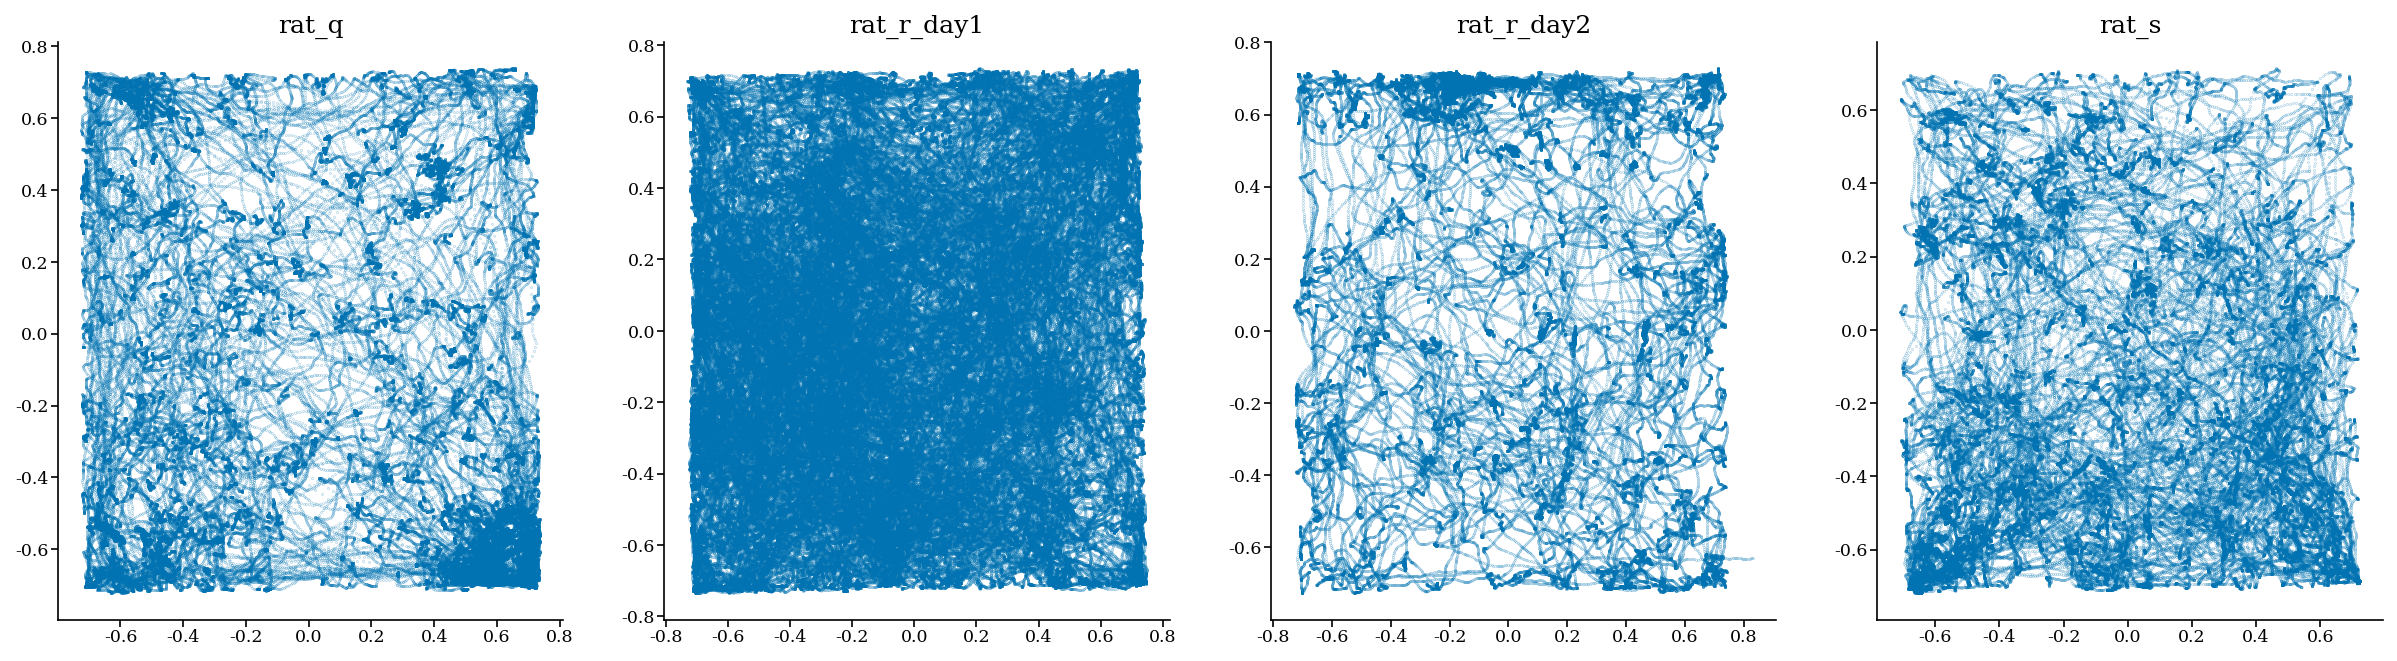

In [11]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
for i, (rat, rat_data) in enumerate(data.items()):
    axs[i].scatter(rat_data['x'], rat_data['y'], s=0.01)
    axs[i].set_title(rat)

In [12]:
res = 32
all_ratemaps = []
for rat_i, data_i in data.items():
    x, y = data_i['x'], data_i['y']
    for module_j, spikes_j in data_i['modules'].items():
        ratemaps_ij = scipy.stats.binned_statistic_2d(x, y, spikes_j, bins=res).statistic
        all_ratemaps.append(ratemaps_ij)

## Calculate grid statistics

In [13]:
import spatial_maps as sm
grid_threshold = 0.4 # <----------------- threshold for gridness score
ratemaps = all_ratemaps[2] # <----------------- select grid module
ratemaps = np.array([astropy.convolution.convolve(ratemaps[i], astropy.convolution.Gaussian2DKernel(2), boundary='wrap') for i in range(ratemaps.shape[0])])

center_peaks = np.array([sm.find_peaks(ratemaps[i])[0] for i in range(ratemaps.shape[0])])
grid_scores = np.array([sm.gridness(ratemap) for ratemap in ratemaps])
acorrs = np.array([sm.autocorrelation(ratemap) for ratemap in ratemaps])
peaks = [sm.find_peaks(acorr) for acorr in acorrs]
thetas = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[1] for peak in peaks])
spacings = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[0] for peak in peaks])
# get the most common spacing and theta
bins=25
hist, bin_edges = np.histogram(spacings, bins=bins)
spacing = bin_edges[np.argmax(hist)] + (bin_edges[1] - bin_edges[0])/2
hist, bin_edges = np.histogram(thetas, bins=bins)
theta = bin_edges[np.argmax(hist)] + (bin_edges[1] - bin_edges[0])/2

from methods import Hexagon, HexagonalGCs
radius = spacing/np.sqrt(3) # spacing is peak-to-peak distance
orientation = theta*180/np.pi - 15 # theta is angle from x-axis
hexagon = HexagonalGCs(f=2/(3*radius), init_rot=orientation)

# mask out non-grid cells
mask = grid_scores > grid_threshold
mask = hexagon.unit_cell.is_in_hexagon(center_peaks-res/2) & mask
print("n=",(mask).sum(), ", N=",len(mask))

# remove stats based on phases outside hexagon and grid scores below threshold
center_peaks = center_peaks[mask]
ratemaps = ratemaps[mask]
thetas = thetas[mask]
spacings = spacings[mask]
grid_scores = grid_scores[mask]

# set phases to hexagon
hexagon.set_phases(center_peaks-res/2) # WRAPPY?

# create random hexagon baseline
random_hexagon = HexagonalGCs(f=2/(3*radius), init_rot=orientation)
random_hexagon.set_phases(random_hexagon.unit_cell.wrap(np.around(random_hexagon.unit_cell.sample(len(center_peaks)))))
print(f"Radius: {radius}, Orientation: {orientation}")

n= 105 , N= 166
Radius: 7.102767803117688, Orientation: -7.130993247402021


Text(0.5, 1.0, 'Gridness')

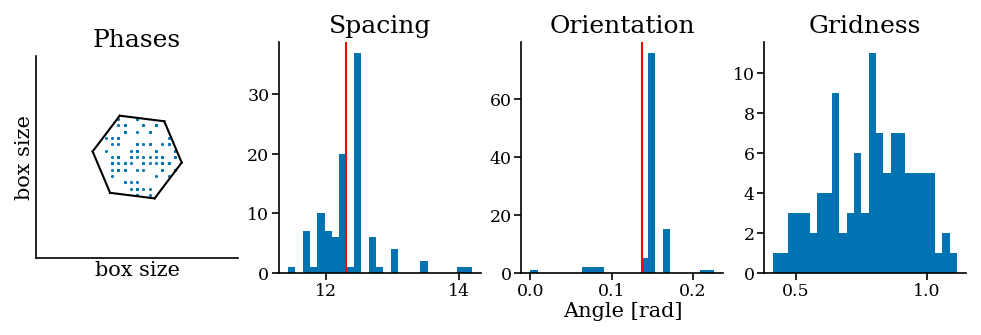

In [14]:
fig, axs = plt.subplots(ncols=4, figsize=(8, 2))
axs[0].scatter(*(center_peaks-res/2).T)
axs[0].set_xlim(-res/2, res/2)
axs[0].set_ylim(-res/2, res/2)
hexagon.unit_cell.plot(fig, axs[0], color='black')#, center=np.zeros(2)+res/2-1)
#ax.scatter(*(center_peaks-res/2).T, color='green', alpha=.2)
axs[0].set_title('Phases')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_aspect('equal')
axs[0].set_xlabel('box size')
axs[0].set_ylabel('box size')
axs[1].hist(spacings, bins=bins)
axs[1].axvline(spacing, color='r')
axs[1].set_title('Spacing')
axs[2].hist(thetas, bins=bins)
axs[2].axvline(theta, color='r')
axs[2].set_title('Orientation')
axs[2].set_xlabel('Angle [rad]')
axs[3].hist(grid_scores, bins=bins)
axs[3].set_title('Gridness')

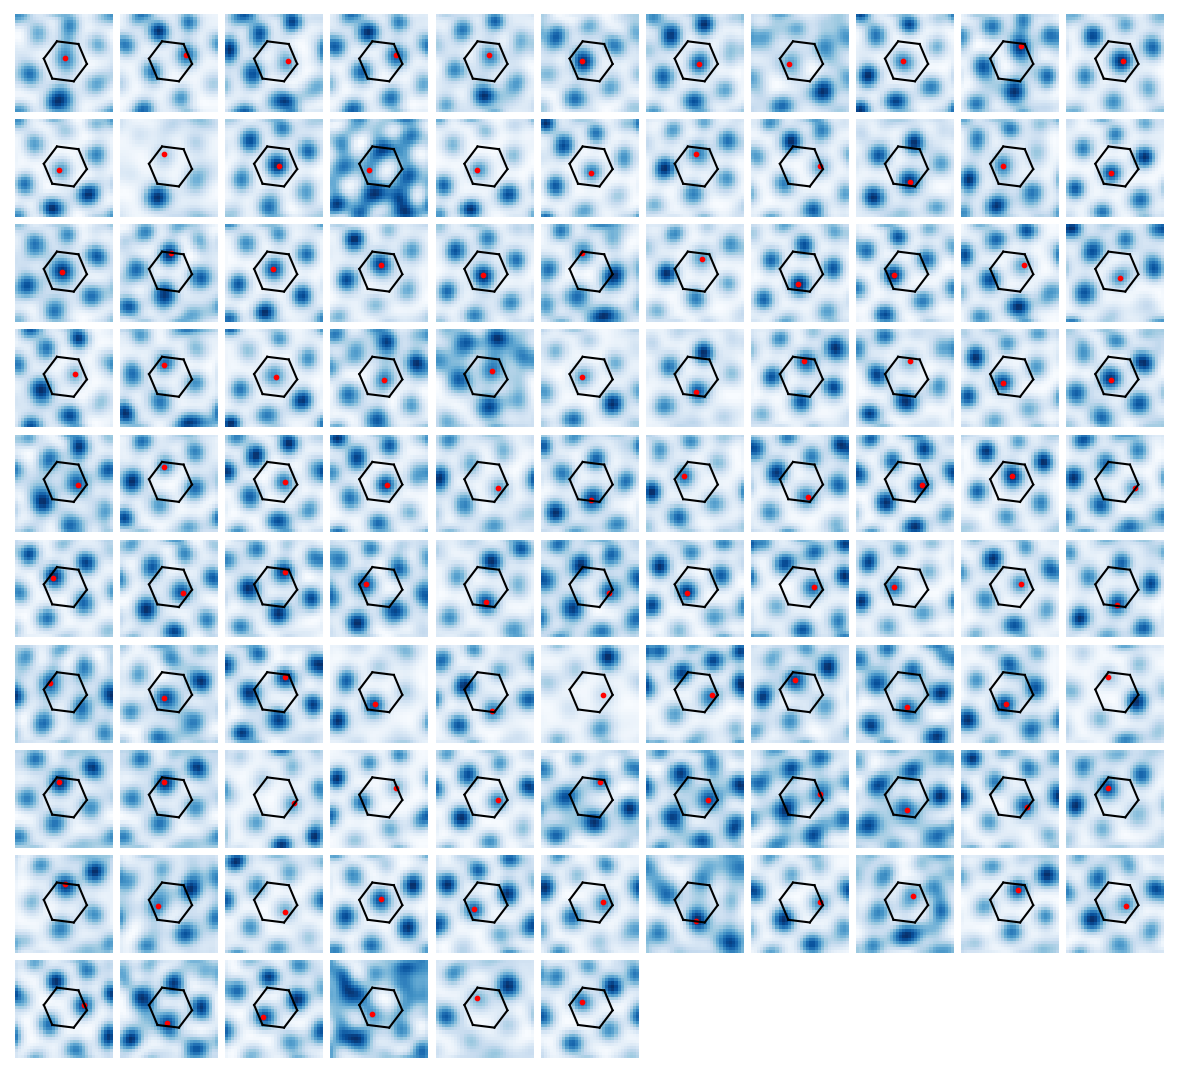

In [15]:
from plotting_functions import multiimshow
fig, axs = multiimshow(ratemaps[np.argsort(grid_scores)[::-1]].transpose(0,2,1), origin='lower', figsize=(8,8), normalize=False);
for i in range(len(center_peaks)):
    axs[i].scatter(*center_peaks[np.argsort(grid_scores)[::-1]][i], color='red', s=3)
    #hexagon.unit_cell.plot(fig, axs[i], center=center_peaks[np.argsort(grid_scores)[::-1]][i], color='black')
    hexagon.unit_cell.plot(fig, axs[i], center=np.ones(2)*res/2, color='black')

In [16]:
np.min(ratemaps)

0.0007648547037022709

In [17]:
dists = np.linalg.norm(ratemaps, axis=0).flatten()
min_dist = np.min(ratemaps) * np.sqrt(len(ratemaps[0]))
max_dist = np.max(ratemaps) * np.sqrt(len(ratemaps[0]))
print(min_dist, max_dist)
min_dist = np.linalg.norm(np.min(ratemaps,axis=(1,2)))
max_dist = np.linalg.norm(np.max(ratemaps,axis=(1,2)))
print(min_dist, max_dist)

0.004326671580882426 1.1306520935275481
0.1735700353305311 1.0436758908295778


(105, 32, 32)

In [18]:
random_dists = np.random.permutation(ratemaps.flatten()).reshape(ratemaps.shape)

random_dists = np.linalg.norm(random_dists,axis=0).flatten()

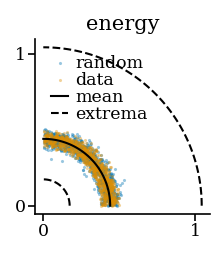

In [36]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
circle_fn = lambda x: np.array([np.cos(x), np.sin(x)]).T
t = np.linspace(0, np.pi/2, 100)
circle_mu = circle_fn(t) * np.mean(dists)
circle_std = circle_fn(t) * np.std(dists)
circle_min = circle_fn(t) * min_dist
circle_max = circle_fn(t) * max_dist
t = np.random.uniform(0, np.pi/2, len(dists))
circle_coords = circle_fn(t)
circle_coords = circle_fn(t) * dists[:, None]
random_circle_coords = circle_fn(t) * random_dists[:, None]
ax.scatter(*random_circle_coords.T, label='random', alpha=0.4)
ax.scatter(*circle_coords.T, label='data', alpha=0.4)
ax.plot(*circle_mu.T, color='black', label='mean')
ax.plot(*circle_min.T, color='black', linestyle='--', label='extrema')
ax.plot(*circle_max.T, color='black', linestyle='--')
ax.set_xticks([ax.get_xticks()[1], ax.get_xticks()[-2]])
ax.set_yticks([ax.get_yticks()[1], ax.get_yticks()[-2]])
ax.set_aspect('equal')
ax.legend()
ax.set_title('energy', fontsize='medium')
# fillbetween with 2*std
#ax.fill_between(circle_mu[:,0] - circle_std[:,0], 
# circle_mu[:,1] - circle_std[:,1], circle_mu[:,1] + circle_std[:,1], color='black', alpha=0.2)
fig.tight_layout(pad=0)
fig.savefig('./results/energy_distribution.pdf')

In [20]:
def random_shift_ratemaps(ratemaps):
    # ratemaps shape: (n_cells, res, res)
    shift = ratemaps.shape[1] - 1
    ratemaps = np.array([np.roll(ratemaps[i], np.random.randint(0, shift), axis=1) for i in range(ratemaps.shape[0])])
    ratemaps = np.array([np.roll(ratemaps[i], np.random.randint(0, shift), axis=0) for i in range(ratemaps.shape[0])])
    return ratemaps

def local_smoothness2(ratemaps):
    # ratemaps shape: (n_cells, res, res)
    from scipy.ndimage import convolve
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    ratemaps = np.array([convolve(ratemaps[i], kernel, mode='constant', cval=0.0) for i in range(ratemaps.shape[0])])
    return ratemaps

def local_smoothness(ratemaps):
    return np.sum(np.diff(ratemaps, axis=1)[:,:,:-1]**2 + np.diff(ratemaps, axis=2)[:,:-1,:]**2)